# CNN in Python

Code and notebook written by Eric Reber and Gregor Kajda, \
Center of Computing in Science Education

In this notebook we present flexible and readable python code for a CNN implemented with NumPy. We will present the code, showcase how to use the codebase and fit a CNN that yields a 99% accuracy on the 28x28 MNIST dataset within reasonable time.

The CNN can be used with all schedulers, cost functions and activation functions presented in  https://github.com/EricEReber/Neural-Network/blob/dev/notebook/Neural-Network.ipynb, which we will also showcase in this notebook before the CNN.

The CNN code consists of different types of Layer classes, including Convolution2DLayer, Pooling2DLayer, FlattenLayer, FullyConnectedLayer and OutputLayer, which can be added to the CNN object using the interface of the CNN class. This allows students to easily construct their own CNN, as well as allowing students to get used to an interface similar to that of TensorFlow which is used for real world applications.

Another important feature of this code is that it throws errors if unreasonable decisions are made (for example using a kernel that is larger than the image, not using a FlattenLayer, etc), and provides the user with an informative error message.

## I. Schedulers
The code below shows object oriented implementations of the Constant, Momentum, Adagrad, AdagradMomentum, RMS prop and Adam schedulers. All of the classes belong to the shared abstract Scheduler class, and share the update_change() and reset() methods allowing for any of the schedulers to be seamlessly used during the training stage, as will later be shown in the fit() method of the neural network. Update_change() only has one parameter, the gradient ($\delta^{l}_{j}a^{l-1}_k$), and returns the change which will be subtracted from the weights. The reset() function takes no parameters, and resets the desired variables. For Constant and Momentum, reset does nothing.

In [1]:
import autograd.numpy as np

class Scheduler:
    """
    Abstract class for Schedulers
    """

    def __init__(self, eta):
        self.eta = eta

    # should be overwritten
    def update_change(self, gradient):
        raise NotImplementedError

    # overwritten if needed
    def reset(self):
        pass


class Constant(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)

    def update_change(self, gradient):
        return self.eta * gradient
    
    def reset(self):
        pass


class Momentum(Scheduler):
    def __init__(self, eta: float, momentum: float):
        super().__init__(eta)
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        self.change = self.momentum * self.change + self.eta * gradient
        return self.change

    def reset(self):
        pass


class Adagrad(Scheduler):
    def __init__(self, eta):
        super().__init__(eta)
        self.G_t = None

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        return self.eta * gradient * G_t_inverse

    def reset(self):
        self.G_t = None


class AdagradMomentum(Scheduler):
    def __init__(self, eta, momentum):
        super().__init__(eta)
        self.G_t = None
        self.momentum = momentum
        self.change = 0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        if self.G_t is None:
            self.G_t = np.zeros((gradient.shape[0], gradient.shape[0]))

        self.G_t += gradient @ gradient.T

        G_t_inverse = 1 / (
            delta + np.sqrt(np.reshape(np.diagonal(self.G_t), (self.G_t.shape[0], 1)))
        )
        self.change = self.change * self.momentum + self.eta * gradient * G_t_inverse
        return self.change

    def reset(self):
        self.G_t = None


class RMS_prop(Scheduler):
    def __init__(self, eta, rho):
        super().__init__(eta)
        self.rho = rho
        self.second = 0.0

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero
        self.second = self.rho * self.second + (1 - self.rho) * gradient * gradient
        return self.eta * gradient / (np.sqrt(self.second + delta))

    def reset(self):
        self.second = 0.0


class Adam(Scheduler):
    def __init__(self, eta, rho, rho2):
        super().__init__(eta)
        self.rho = rho
        self.rho2 = rho2
        self.moment = 0
        self.second = 0
        self.n_epochs = 1

    def update_change(self, gradient):
        delta = 1e-8  # avoid division ny zero

        self.moment = self.rho * self.moment + (1 - self.rho) * gradient
        self.second = self.rho2 * self.second + (1 - self.rho2) * gradient * gradient

        moment_corrected = self.moment / (1 - self.rho**self.n_epochs)
        second_corrected = self.second / (1 - self.rho2**self.n_epochs)

        return self.eta * moment_corrected / (np.sqrt(second_corrected + delta))

    def reset(self):
        self.n_epochs += 1
        self.moment = 0
        self.second = 0

## Usage of schedulers

To initalize a scheduler, simply create the object and pass in the necessary parameters such as the learning rate and the momentum as shown below. As the Scheduler class is an abstract class it should not called directly, and will raise an error upon usage.


In [2]:
momentum_scheduler = Momentum(eta=1e-3, momentum=0.9)
adam_scheduler = Adam(eta=1e-3, rho=0.9, rho2=0.999)

Here is a small example for how a segment of code using schedulers could look. Switching out the schedulers is simple.

In [3]:
weights = np.ones((3,3))
print(f"Before scheduler:\n{weights=}")

epochs = 10
for e in range(epochs):
    gradient = np.random.rand(3, 3)
    change = adam_scheduler.update_change(gradient)
    weights = weights - change
    adam_scheduler.reset()

print(f"\nAfter scheduler:\n{weights=}")

Before scheduler:
weights=array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

After scheduler:
weights=array([[0.99399317, 0.993993  , 0.993993  ],
       [0.99399301, 0.99399302, 0.99399312],
       [0.99399301, 0.99399301, 0.99399303]])


## II. Cost functions

In this section we will quickly look at cost functions that can be used when creating the neural network. Every cost function takes the target vector as its parameter, and returns a function valued only at X such that it may easily be differentiated.


In [4]:
def CostOLS(target):
    """
    Return OLS function valued only at X, so
    that it may be easily differentiated
    """

    def func(X):
        return (1.0 / target.shape[0]) * np.sum((target - X) ** 2)

    return func


def CostLogReg(target):
    """
    Return Logistic Regression cost function
    valued only at X, so that it may be easily differentiated
    """

    def func(X):
        return -(1.0 / target.shape[0]) * np.sum(
            (target * np.log(X + 10e-10)) + ((1 - target) * np.log(1 - X + 10e-10))
        )

    return func


def CostCrossEntropy(target):
    """
    Return cross entropy cost function valued only at X, so
    that it may be easily differentiated
    """
    
    def func(X):
        return -(1.0 / target.size) * np.sum(target * np.log(X + 10e-10))

    return func


## Usage of cost functions

Below we will provide a short example of how these cost function may be used to obtain results if you wish to test them out on your own using AutoGrad's automatic differentiation.


In [11]:
from autograd import grad

target = np.array([[1, 2, 3]]).T
a = np.array([[4, 5, 6]]).T

cost_func = CostCrossEntropy
cost_func_derivative = grad(cost_func(target))

valued_at_a = cost_func_derivative(a)
print(f"Derivative of cost function {cost_func.__name__} valued at a:\n{valued_at_a}")

Derivative of cost function CostCrossEntropy valued at a:
[[-0.08333333]
 [-0.13333333]
 [-0.16666667]]


## III. Activation functions

Finally, before we look at the layers that make up the neural network, we will look at the activation functions which can be specified between the hidden layers and as the output function. Each function can be valued for any given vector or matrix X, and can be differentiated via derivate().


In [7]:
import autograd.numpy as np
from autograd import elementwise_grad

def identity(X):
    return X


def sigmoid(X):
    try:
        return 1.0 / (1 + np.exp(-X))
    except FloatingPointError:
        return np.where(X > np.zeros(X.shape), np.ones(X.shape), np.zeros(X.shape))


def softmax(X):
    X = X - np.max(X, axis=-1, keepdims=True)
    delta = 10e-10
    return np.exp(X) / (np.sum(np.exp(X), axis=-1, keepdims=True) + delta)


def RELU(X):
    return np.where(X > np.zeros(X.shape), X, np.zeros(X.shape))


def LRELU(X):
    delta = 10e-4
    return np.where(X > np.zeros(X.shape), X, delta * X)


def derivate(func):
    if func.__name__ == "RELU":

        def func(X):
            return np.where(X > 0, 1, 0)

        return func

    elif func.__name__ == "LRELU":

        def func(X):
            delta = 10e-4
            return np.where(X > 0, 1, delta)

        return func

    else:
        return elementwise_grad(func)


## Usage of activation functions

Below is a short demonstration of how to use an activation function. The derivative of the activation function will be important when calculating the output delta term during backpropagation. Note that derivate() can also be used for cost functions for a more generalized approach.


In [12]:
z = np.array([[4, 5, 6]]).T
print(f"Input to activation function:\n{z}")

act_func = sigmoid
a = act_func(z)
print(f"\nOutput from {act_func.__name__} activation function:\n{a}")

act_func_derivative = derivate(act_func)
valued_at_z = act_func_derivative(a)
print(f"\nDerivative of {act_func.__name__} activation function valued at z:\n{valued_at_z}")

Input to activation function:
[[4]
 [5]
 [6]]

Output from sigmoid activation function:
[[0.98201379]
 [0.99330715]
 [0.99752738]]

Derivative of sigmoid activation function valued at z:
[[0.19824029]
 [0.19721923]
 [0.19683648]]


## IV. Convolution

To construct a convolutional neural network (CNN), it's important to understand the basic principles of convolution and how it helps us extract information from images. Convolution itself is nothing more than a mathematical operation between two functions that produces another function. It's represented by an integral between two functions, which is typically written as:

$$(f \ast g)(t):=\int_{-\infty}^{\infty} f(\tau) g(t-\tau) d \tau$$

Here, f and g are the two functions that we want to operate on. The result of the convolution operation is denoted by f * g, and it's obtained by sliding the function g over f and computing the integral of their product at each position. In the case of the functions being continouos, convolution takes the form shown above, while if we discretize both f and g, the operation of convolution will take the form of a sum between the elements of f and g: 

$$(f \ast g)[n]=\sum_{m=0}^{n-1} f[m] g[n-m]$$

Now the key idea which we will utilize to extract information contained in the image, is to slide a function g over a function f. Hence, nn our case, f becomes the picture, while g becomes the filter. However, since our convolution will be a two dimensional variant, we have to extend our mathematical formula with an extra summation symbol: 

$$(f \ast g)[i, j]\sum_{m=0}^{M-1}\sum_{n=0}^{N-1} f[m,n] g[i-m, j-n]$$

Now to give you an example of how 2D convolution works in practice, suppose we have a picture of dimension 6 x 6

\begin{bmatrix}
4 & 1 & 2 & 9 & 8 & 6 \\
9 & 5 & 9 & 5 & 8 & 5 \\
1 & 5 & 9 & 7 & 6 & 4 \\
2 & 9 & 8 & 3 & 7 & 1 \\
8 & 1 & 6 & 4 & 2 & 2 \\
1 & 0 & 5 & 7 & 8 & 2 \\
\end{bmatrix}

and a 3x3 low-pass filter 

$$\frac{1}{9} 
\begin{bmatrix}
1 & 1 & 1 \\
1 & 1 & 1 \\
1 & 1 & 1 \\
\end{bmatrix}
$$

In order to filter the image, we have to extract a 3 x 3 element from its upper left corner, and perform element-wise multiplication of the extracted image pixels with the elements of the filter:

$$
\begin{bmatrix}
4 & 1 & 2 \\
9 & 5 & 9 \\
1 & 5 & 9 \\ 
\end{bmatrix} 
\cdot
\begin{bmatrix}
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\frac{1}{9} & \frac{1}{9} & \frac{1}{9} \\
\end{bmatrix}
= 
\begin{bmatrix}
\frac{4}{9} & \frac{1}{9} & \frac{2}{9} \\
\frac{9}{9} & \frac{5}{9} & \frac{9}{9} \\
\frac{1}{9} & \frac{5}{9} & \frac{9}{9} \\
\end {bmatrix}
= \textbf{A}
$$

Then, following the multiplication, we summarize the elements of the resulting matrix A:

$$
(f \ast g)[0, 0]= \sum_{i=0}^{2} \sum_{j=0}^{2} a_{i,j} = 5
$$

Which corresponds to the first element of the filtered image: 

\begin{bmatrix}
5 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{bmatrix}

Using a value of 1 for the parameter called *stride*, denoted *s*, along both axes of the image, we silde the filter one index to the right, and repeat the calculations. When we reach the right border of the image, we simply jump one row down, since *s*=1 along along both axes, and starting from left again, repeat the operation until the whole image has been filtered. The full result of the convolution is: 

\begin{bmatrix}
5 & 5.78 & 7 & 6.44 \\ 
6.33 & 6.67 & 6.89 & 5.11 \\
5.44 & 5.78 & 5.78 & 4 \\
4.44 & 4.78 & 5.56 & 4 \\
\end{bmatrix}

As you can see, the result is smaller than the original image. This is the result of convoultion if we do not *pad* the borders with extra rows and columns, the image reduces in size. In order to avoid this downsizing of our input image, we have to pad the borders with c additional columns and r additional rows: 

$$r =\lfloor \frac{kh}{2} \rfloor \cdot 2$$ 
$$c =\lfloor \frac{kw}{2} \rfloor \cdot 2$$ 

Using those simple equations, we find out by how much we have to extend the dimensions of the original image. Before proceeding, however, what shall we fill the additional rows and columns with? One of the most common approaches to padding, is the so called *zero-paddoing*, which as the name suggest, involves filling the rows and columns with zeros. This is the approach that we will be using here. If we apply this padding to out original 6 x 6 image, the result will we an 8 x 8 image with borders filled with zeros: 

\begin{bmatrix}
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
0 & 4 & 1 & 2 & 9 & 8 & 6 & 0 \\
0 & 9 & 5 & 9 & 5 & 8 & 5 & 0 \\
0 & 1 & 5 & 9 & 7 & 6 & 4 & 0 \\
0 & 2 & 9 & 8 & 3 & 7 & 1 & 0 \\
0 & 8 & 1 & 6 & 4 & 2 & 2 & 0 \\
0 & 1 & 0 & 5 & 7 & 8 & 2 & 0 \\
0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{bmatrix}

Now as you will see when we run the code, the size of the image will remain unchanged

In [48]:
import numpy as np

# padding function which will extend out image with zeros
def padding(img, kernel):
    new_height = img.shape[0] + (kernel.shape[0] // 2) * 2
    new_width = img.shape[1] + (kernel.shape[1] // 2) * 2
    k_height = kernel.shape[0] // 2

    padded_img = np.zeros((new_height, new_width))

    padded_img[k_height : new_height - k_height, k_height : new_width - k_height] = img[
        :, :
    ]

    return padded_img

image = np.array([[4, 1, 2, 9, 8, 6],
                 [9, 5, 9, 5, 8, 5],
                 [1, 5, 9, 7, 6, 4],
                 [2, 9, 8, 3, 7, 1],
                 [8, 1, 6, 4, 2, 2],
                 [1, 0, 5, 7, 8, 2]])

kernel = (1/9)*np.ones((3,3))

padded_image = padding(image, kernel)


"""
When filtering images, you will see that convolution involves rotating the filter by 180 degrees. 
However, this is not the case when applying convolution in a CNN, where the operation we use is often called 
cross-correlation when not used in a neural network.
"""
 


for i in range(2):
    kernel = np.rot90(kernel)

# The kernel is quadratic, thus we only need one of its dimensions
half_dim = kernel.shape[0] // 2
conv_image = np.zeros(image.shape)

for i in range(half_dim, conv_image.shape[0] + half_dim, stride):
    for j in range(half_dim, conv_image.shape[1] + half_dim, stride):
        conv_image[i - half_dim, j - half_dim] = np.sum(
            padded_image[
                i - half_dim : i + half_dim + 1, j - half_dim : j + half_dim + 1
            ]
            * kernel
        )

print(np.around(conv_image, decimals=2))

"""AS you can see, the ersulting image is of the same size as the original image"""


[[2.11 3.33 3.44 4.56 4.56 3.  ]
 [2.78 5.   5.78 7.   6.44 4.11]
 [3.44 6.33 6.67 6.89 5.11 3.44]
 [2.89 5.44 5.78 5.78 4.   2.44]
 [2.33 4.44 4.78 5.56 4.   2.44]
 [1.11 2.33 2.56 3.56 2.78 1.56]]


'AS you can see, the ersulting image is of the same size as the original image'

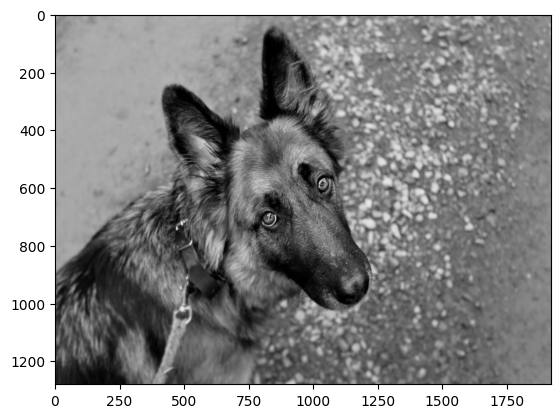

Time taken for convolution on 128x128 image 30.13426685333252


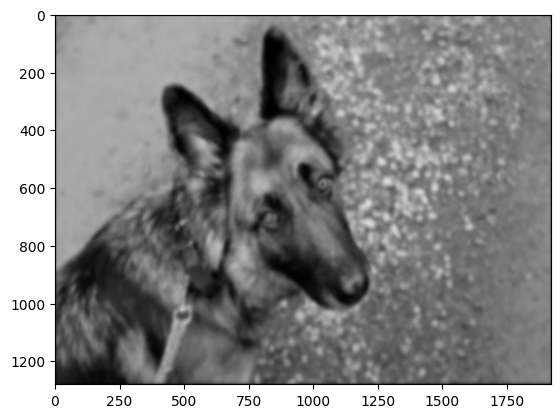

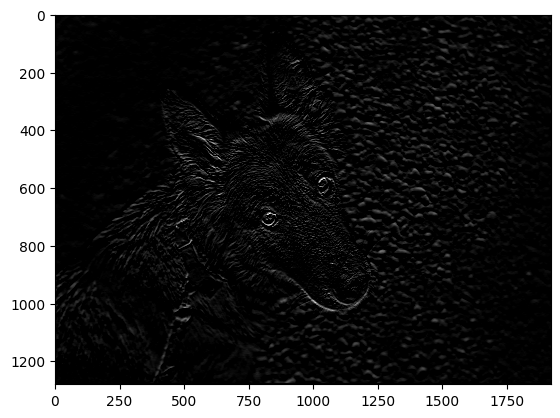

In [17]:
# Now an example using a real image and first a gaussian low-pass filter and then a sobel filter
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import time

def padding(img, kernel):
    new_height = img.shape[0] + (kernel.shape[0] // 2) * 2
    new_width = img.shape[1] + (kernel.shape[1] // 2) * 2
    k_height = kernel.shape[0] // 2

    padded_img = np.zeros((new_height, new_width))

    padded_img[k_height : new_height - k_height, k_height : new_width - k_height] = img[
        :, :
    ]

    return padded_img

def generate_gauss_mask(sigma, K=1):
    side = np.ceil(1 + 8 * sigma)
    y, x = np.mgrid[-side // 2 + 1 : (side // 2) + 1, -side // 2 + 1 : (side // 2) + 1]
    ker_coef = K / (2 * np.pi * sigma**2)
    g = np.exp(-((x**2 + y**2) / (2.0 * sigma**2)))

    return g, ker_coef


def conv2D(image, kernel, stride=1, pad="zero"):
    for i in range(2):
        kernel = np.rot90(kernel)

    # The kernel is quadratic, thus we only need one of its dimensions
    half_dim = kernel.shape[0] // 2

    if pad == "zero":
        conv_image = np.zeros(image.shape)
        pad_image = padding(image, kernel)
    else:
        conv_image = np.zeros(
            (image.shape[0] - kernel.shape[0], image.shape[1] - kernel.shape[1])
        )
        pad_image = image[:, :]

    for i in range(half_dim, conv_image.shape[0] + half_dim, stride):
        for j in range(half_dim, conv_image.shape[1] + half_dim, stride):
            conv_image[i - half_dim, j - half_dim] = np.sum(
                pad_image[
                    i - half_dim : i + half_dim + 1, j - half_dim : j + half_dim + 1
                ]
                * kernel
            )

    return conv_image

img_path = "../data/IMG-2167.JPG"
image_of_cute_dog = imageio.imread(img_path, mode='L')

plt.imshow(image_of_cute_dog, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.show()

gauss, kernel = generate_gauss_mask(sigma=6)
gauss_filter = gauss*kernel

start_time = time.time()
filtered_image = conv2D(image_of_cute_dog, kernel=gauss_filter)
print(f'Time taken for convolution on 128x128 image {time.time() - start_time}')
plt.imshow(filtered_image, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.show()

sobel_x = np.array([[1, 0, 1],
                    [2, 0, -2],
                    [1, 0, -1]])

sobel_y = np.array([[1, 2, 1],
                    [0, 0, 0], 
                    [-1, -2, -1]])

filtered_image = conv2D(image_of_cute_dog, kernel=sobel_y)

plt.imshow(filtered_image, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.show()



## Remarks on the speed 

Although our naive algorithm for convolution finished pretty quickly, 0.18 seconds is still quite slow when considering that we have only processed one image. The time complexity of 2D convolution, which is O(NMnm), rapidly becomes a restriction and can in the worst make it impossible to perform computations. Thus, optimizing the naive 2D convolution algorithm is a necessity, because as the size of the input data increases, the execution time of the algorithm also increases significantly. This can become a bottleneck in applications that require real-time processing of large amounts of data, such as image and video processing, deep learning, and scientific simulations

Here, we will present two commonly used techniques for optimizion, which are the separable kernel approach and Fast Fourier Transform (FFT). Both of these methods can significantly reduce the computational complexity of convolution and improve the overall efficiency of processing large amounts of data. We won't go into the details of those algorithms, although strongly encourage you to study at least the way FFT is used in order to optimize the computations. 

## Convolution using separable kernels

Time taken for convolution with seperated kernel on 128x128 image 16.627753734588623


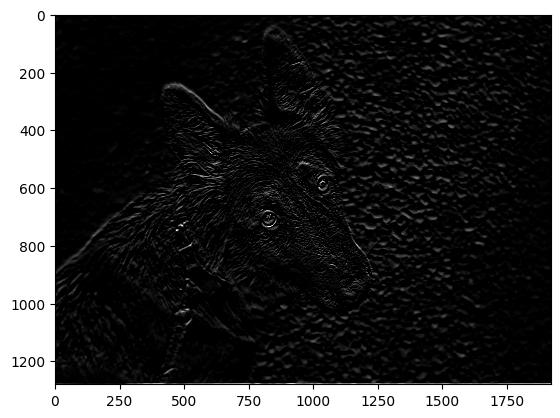

In [14]:

def conv2DSep(image, kernel, coef, stride=1, pad="zero"):
    for i in range(2):
        kernel = np.rot90(kernel)

    # The kernel is quadratic, thus we only need one of its dimensions
    half_dim = kernel.shape[0] // 2

    ker1 = np.array(kernel[0, :])
    ker2 = np.array(kernel[:, 0])

    if pad == "zero":
        conv_image = np.zeros(image.shape)
        pad_image = padding(image, kernel)
    else:
        conv_image = np.zeros(
            (image.shape[0] - kernel.shape[0], image.shape[1] - kernel.shape[1])
        )
        pad_image = image[:, :]

    for i in range(half_dim, conv_image.shape[0] + half_dim, stride):
        for j in range(half_dim, conv_image.shape[1] + half_dim, stride):
            conv_image[i - half_dim, j - half_dim] = (
                pad_image[
                    i - half_dim : i + half_dim + 1, j - half_dim : j + half_dim + 1
                ]
                @ ker1
                @ ker2.T
                * coef
            )

    return conv_image

start_time = time.time()
filtered_image = conv2DSep(image_of_cute_dog, kernel=sobel_y, coef=1)
print(f'Time taken for convolution with seperated kernel on 128x128 image {time.time() - start_time}')
plt.imshow(filtered_image, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.show()


## Convolution in the Fourier domain

Time take for convolution in the fourier domain: 0.3834056854248047


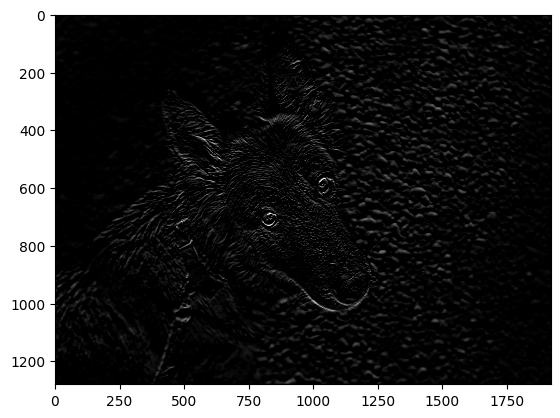

In [15]:
start_time = time.time()
img_fft = np.fft.fft2(image_of_cute_dog)
kernel_fft = np.fft.fft2(sobel_y, s=image_of_cute_dog.shape)

conv_image = img_fft * kernel_fft

filtered_image = np.fft.ifft2(conv_image)
print(f'Time take for convolution in the fourier domain: {time.time() - start_time}')
plt.imshow(filtered_image.real, cmap="gray", vmin=0, vmax=255, aspect="auto")
plt.show()



As you can see, performing convolution in the fourier domain leads to the fastest computation time, however beware the fact that for images of sufficiently small dimensions, one of the methods above may prove faster than FFT improved convolution. This slight inconvenience is caused by the overhead of transfering both the image and filter into the fourier domain, and later back into the spatial domain. Thus be aware of this when using FFT as your primary optimization method. 

### Convolution in a hidden layer

Now that we have built the fundamental understanding of how to apply convolution to spatial data, we can move on to discussing the details behind a convolutional layer of a CNN. 

## IV The Layers

Now that we have a good understanding of the components used in the CNN, we will take a look at the various layers used in the CNN, including Convolution2DLayer, Convolution2DLayerOPT (and optimized version of the Convoltuion2DLayer, Pooling2DLayer, FlattenLayer, FullyConnectedLayer and OutputLayer, which can be used to make custom convolutional neural networks.

## Usage of layers

The layers will usually be used within the CNN class rather than on their own. If one wishes to construct a regular feed forward neural network using these layers, it would have to start from the FlattenLayer due to technical details regarding the weight initiation.

For Convolution2DLayer, we have specifically implemented a weight initiation such that it can be used on its own such that we can better visualize convolution.

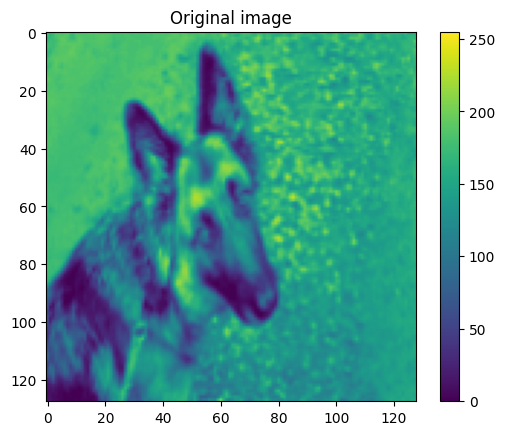

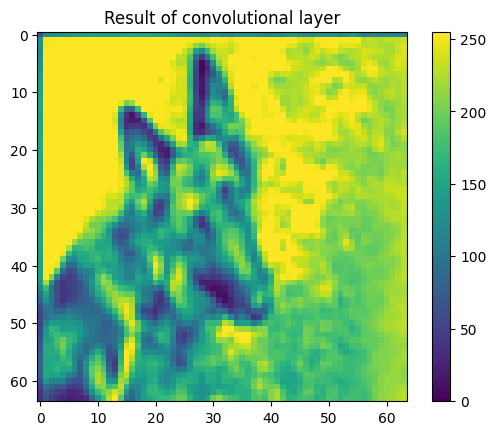

In [50]:
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt

def plot_convolution_result(X, layer):
    plt.imshow(X[0, 0, :, :], vmin=0, vmax=255)
    plt.title("Original image")
    plt.colorbar()
    plt.show()
    conv_result = layer._feedforward(X)
    plt.title("Result of convolutional layer")
    plt.imshow(conv_result[0, 0, :, :], vmin=0, vmax=255)
    plt.colorbar()
    plt.show()

# create layer
layer = Convolution2DLayerOPT(
    input_channels=3,
    feature_maps=1,
    kernel_height=4,
    kernel_width=4,
    v_stride=2,
    h_stride=2,
    pad="same",
    act_func=identity,
    seed=2023,
    )

# read in image path, make data correct format
img_path = "../data/luna.JPG"
image_of_cute_dog = imageio.imread(img_path)
image_shape = image_of_cute_dog.shape
image_of_cute_dog = image_of_cute_dog.reshape(1, image_shape[0], image_shape[1], image_shape[2])
image_of_cute_dog = image_of_cute_dog.transpose(0, 3, 1, 2)

# plot the result of the convolution
plot_convolution_result(image_of_cute_dog, layer)


From the images, you can see that the result has half the pixels on each axis due to the fact that we've used a horizontal and vertical stride of 2. We can also see that the convolutional layer has to some degree seperated the dog from the background, which will be useful later for the classifier.

Note that image data usually comes in many different shapes and sizes, but for our CNN we require the input data be formatted as \[Number of inputs, input channels, input height, input width\]. Occasionally, the data you come accross use will be formatted like this, but on many occasions reshaping and transposing the dimensions is sadly necessary.

## The Convolutional Neural Network (CNN)

Finally, we will present the code for the CNN. The CNN class organizes all the layers, and allows for training on image data.

In [51]:
import math
import autograd.numpy as np
import sys
import warnings
from src.Schedulers import *
from src.activationFunctions import *
from src.costFunctions import *
from src.Layers import *
from autograd import grad, elementwise_grad
from random import random, seed
from copy import deepcopy
from typing import Tuple, Callable
from sklearn.utils import resample
from collections import OrderedDict


warnings.simplefilter("error")


class CNN:
    def __init__(
        self,
        cost_func: Callable = CostCrossEntropy,
        scheduler: Scheduler = Adam(eta=1e-4, rho=0.9, rho2=0.999),
        seed: int = None,
    ):
        """
        Description:
        ------------
            Instantiates CNN object

        Parameters:
        ------------
            I   output_func (costFunctions) cost function for feed forward neural network part of CNN,
                such as "CostLogReg", "CostOLS" or "CostCrossEntropy"

            II  scheduler (Scheduler) optional parameter, default set to Adam. Can also be set to other
                schedulers such as AdaGrad, Momentum, RMS_prop and Constant. Note that schedulers have
                to be instantiated first with proper parameters (for example eta, rho and rho2 for Adam)

            III seed (int) used for seeding all random operations
        """
        self.layers = list()
        self.cost_func = cost_func
        self.scheduler = scheduler
        self.schedulers_weight = list()
        self.schedulers_bias = list()
        self.seed = seed
        self.pred_format = None

    def add_FullyConnectedLayer(
        self, nodes: int, act_func=LRELU, scheduler=None
    ) -> None:
        """
        Description:
        ------------
            Add a FullyConnectedLayer to the CNN, i.e. a hidden layer in the feed forward neural
            network part of the CNN. Often called a Dense layer in literature

        Parameters:
        ------------
            I   nodes (int) number of nodes in FullyConnectedLayer
            II  act_func (activationFunctions) activation function of FullyConnectedLayer,
                such as "sigmoid", "RELU", "LRELU", "softmax" or "identity"
            III scheduler (Scheduler) optional parameter, default set to Adam. Can also be set to other
                schedulers such as AdaGrad, Momentum, RMS_prop and Constant
        """
        assert self.layers, "FullyConnectedLayer should follow FlattenLayer in CNN"

        if scheduler is None:
            scheduler = self.scheduler

        layer = FullyConnectedLayer(nodes, act_func, scheduler, self.seed)
        self.layers.append(layer)

    def add_OutputLayer(self, nodes: int, output_func=sigmoid, scheduler=None) -> None:
        """
        Description:
        ------------
            Add an OutputLayer to the CNN, i.e. a the final layer in the feed forward neural
            network part of the CNN

        Parameters:
        ------------
            I   nodes (int) number of nodes in OutputLayer. Set nodes=1 for binary classification and
                nodes = number of classes for multi-class classification
            II  output_func (activationFunctions) activation function for the output layer, such as
                "identity" for regression, "sigmoid" for binary classification and "softmax" for multi-class
                classification
            III scheduler (Scheduler) optional parameter, default set to Adam. Can also be set to other
                schedulers such as AdaGrad, Momentum, RMS_prop and Constant
        """
        assert self.layers, "OutputLayer should follow FullyConnectedLayer in CNN"

        if scheduler is None:
            scheduler = self.scheduler

        output_layer = OutputLayer(
            nodes, output_func, self.cost_func, scheduler, self.seed
        )
        self.layers.append(output_layer)
        self.pred_format = output_layer.get_pred_format()

    def add_FlattenLayer(self, act_func=LRELU) -> None:
        """
        Description:
        ------------
            Add a FlattenLayer to the CNN, which flattens the image data such that it is formatted to
            be used in the feed forward neural network part of the CNN
        """
        self.layers.append(FlattenLayer(act_func=act_func, seed=self.seed))

    def add_Convolution2DLayer(
        self,
        input_channels=1,
        feature_maps=3,
        kernel_height=32,
        kernel_width=32,
        v_stride=1,
        h_stride=1,
        pad="same",
        act_func=LRELU,
        optimized=True,
    ) -> None:
        """
        Description:
        ------------
            Add a Convolution2DLayer to the CNN, i.e. a convolutional layer with a 2 dimensional kernel. Should be
            the first layer added to the CNN

        Parameters:
        ------------
            I   input_channels (int) specifies amount of input channels. For monochrome images, use input_channels
                = 1, and input_channels = 3 for colored images, where each channel represents one of R, G and B
            II  feature_maps (int) amount of feature maps in CNN
            III kernel_height (int) height of the kernel, also called 'convolutional filter' in literature
            IV  kernel_width (int) width of the kernel, also called 'convolutional filter' in literature
            V   v_stride (int) value of vertical stride for dimentionality reduction
            VI  h_stride (int) value of horizontal stride for dimentionality reduction
            VII pad (str) default = "same" ensures output size is the same as input size (given stride=1)
           VIII act_func (activationFunctions) default = "LRELU", nonlinear activation function
             IX optimized (bool) default = True, uses Convolution2DLayerOPT if True which is much faster when
                compared to Convolution2DLayer, which is a more straightforward, understandable implementation
        """
        if optimized:
            conv_layer = Convolution2DLayerOPT(
                input_channels,
                feature_maps,
                kernel_height,
                kernel_width,
                v_stride,
                h_stride,
                pad,
                act_func,
                self.seed,
                reset_self=False,
            )
        else:
            conv_layer = Convolution2DLayer(
                input_channels,
                feature_maps,
                kernel_height,
                kernel_width,
                v_stride,
                h_stride,
                pad,
                act_func,
                self.seed,
                reset_self=False,
            )
        self.layers.append(conv_layer)

    def add_PoolingLayer(
        self, kernel_height=2, kernel_width=2, v_stride=1, h_stride=1, pooling="max"
    ) -> None:
        """
        Description:
        ------------
            Add a Pooling2DLayer to the CNN, i.e. a pooling layer that reduces the dimentionality of
            the image data. It is not necessary to use a Pooling2DLayer when creating a CNN, but it
            can be used to speed up the training

        Parameters:
        ------------
            I   kernel_height (int) height of the kernel used for pooling
            II  kernel_width (int) width of the kernel used for pooling
            III v_stride (int) value of vertical stride for dimentionality reduction
            IV  h_stride (int) value of horizontal stride for dimentionality reduction
            V   pooling (str) either "max" or "average", describes type of pooling performed
        """
        pooling_layer = Pooling2DLayer(
            kernel_height, kernel_width, v_stride, h_stride, pooling, self.seed
        )
        self.layers.append(pooling_layer)

    def fit(
        self,
        X: np.ndarray,
        t: np.ndarray,
        epochs: int = 100,
        lam: float = 0,
        batches: int = 1,
        X_val: np.ndarray = None,
        t_val: np.ndarray = None,
    ) -> dict:
        """
        Description:
        ------------
            Fits the CNN to input X for a given amount of epochs. Performs feedforward and backpropagation passes,
            can utilize batches, regulariziation and validation if desired.

        Parameters:
        ------------
            X (numpy array) with input data in format [images, input channels,
            image height, image_width]
            t (numpy array) target labels for input data
            epochs (int) amount of epochs
            lam (float) regulariziation term lambda
            batches (int) amount of batches input data splits into
            X_val (numpy array) validation data
            t_val (numpy array) target labels for validation data

        Returns:
        ------------
            scores (dict) a dictionary with "train_error", "train_acc", "val_error", val_acc" keys
            that contain numpy arrays with float values of all accuracies/errors over all epochs.
            Can be used to create plots. Also used to update the progress bar during training
        """

        # setup
        if self.seed is not None:
            np.random.seed(self.seed)

        # initialize weights
        self._initialize_weights(X)

        # create arrays for score metrics
        scores = self._initialize_scores(epochs)

        assert batches <= t.shape[0]
        batch_size = X.shape[0] // batches

        try:
            for epoch in range(epochs):
                for batch in range(batches):
                    # minibatch gradient descent
                    # If the for loop has reached the last batch, take all thats left
                    if batch == batches - 1:
                        X_batch = X[batch * batch_size :, :, :, :]
                        t_batch = t[batch * batch_size :, :]
                    else:
                        X_batch = X[
                            batch * batch_size : (batch + 1) * batch_size, :, :, :
                        ]
                        t_batch = t[batch * batch_size : (batch + 1) * batch_size, :]

                    self._feedforward(X_batch)
                    self._backpropagate(t_batch, lam)

                # reset schedulers for each epoch (some schedulers pass in this call)
                for layer in self.layers:
                    if isinstance(layer, FullyConnectedLayer):
                        layer._reset_scheduler()

                # computing performance metrics
                scores = self._compute_scores(scores, epoch, X, t, X_val, t_val)

                # printing progress bar
                print_length = self._progress_bar(
                    epoch,
                    epochs,
                    scores,
                )
        # allows for stopping training at any point and seeing the result
        except KeyboardInterrupt:
            pass

        # visualization of training progression (similiar to tensorflow progression bar)
        sys.stdout.write("\r" + " " * print_length)
        sys.stdout.flush()
        self._progress_bar(
            epochs,
            epochs,
            scores,
        )
        sys.stdout.write("")

        return scores

    def _feedforward(self, X_batch) -> np.ndarray:
        """
        Description:
        ------------
            Performs the feedforward pass for all layers in the CNN. Called from fit()
        """
        a = X_batch
        for layer in self.layers:
            a = layer._feedforward(a)

        return a

    def _backpropagate(self, t_batch, lam) -> None:
        """
        Description:
        ------------
            Performs backpropagation for all layers in the CNN. Called from fit()
        """
        assert len(self.layers) >= 2
        reversed_layers = self.layers[::-1]

        # for every layer, backwards
        for i in range(len(reversed_layers) - 1):
            layer = reversed_layers[i]
            prev_layer = reversed_layers[i + 1]

            # OutputLayer
            if isinstance(layer, OutputLayer):
                prev_a = prev_layer.get_prev_a()
                weights_next, delta_next = layer._backpropagate(t_batch, prev_a, lam)

            # FullyConnectedLayer
            elif isinstance(layer, FullyConnectedLayer):
                assert (
                    delta_next is not None
                ), "No OutputLayer to follow FullyConnectedLayer"
                assert (
                    weights_next is not None
                ), "No OutputLayer to follow FullyConnectedLayer"
                prev_a = prev_layer.get_prev_a()
                weights_next, delta_next = layer._backpropagate(
                    weights_next, delta_next, prev_a, lam
                )

            # FlattenLayer
            elif isinstance(layer, FlattenLayer):
                assert (
                    delta_next is not None
                ), "No FullyConnectedLayer to follow FlattenLayer"
                assert (
                    weights_next is not None
                ), "No FullyConnectedLayer to follow FlattenLayer"
                delta_next = layer._backpropagate(weights_next, delta_next)

            # Convolution2DLayer and Convolution2DLayerOPT
            elif isinstance(layer, Convolution2DLayer):
                assert (
                    delta_next is not None
                ), "No FlattenLayer to follow Convolution2DLayer"
                delta_next = layer._backpropagate(delta_next)

            # Pooling2DLayer
            elif isinstance(layer, Pooling2DLayer):
                assert delta_next is not None, "No Layer to follow Pooling2DLayer"
                delta_next = layer._backpropagate(delta_next)

            # Catch error
            else:
                raise NotImplementedError

    def _compute_scores(
        self,
        scores: dict,
        epoch: int,
        X: np.ndarray,
        t: np.ndarray,
        X_val: np.ndarray,
        t_val: np.ndarray,
    ) -> dict:
        """
        Description:
        ------------
            Computes scores such as training error, training accuracy, validation error
            and validation accuracy for the CNN depending on if a validation set is used
            and if the CNN performs classification or regression

        Returns:
        ------------
            scores (dict) a dictionary with "train_error", "train_acc", "val_error", val_acc" keys
            that contain numpy arrays with float values of all accuracies/errors over all epochs.
            Can be used to create plots. Also used to update the progress bar during training
        """

        pred_train = self.predict(X)
        cost_function_train = self.cost_func(t)
        train_error = cost_function_train(pred_train)
        scores["train_error"][epoch] = train_error

        if X_val is not None and t_val is not None:
            cost_function_val = self.cost_func(t_val)
            pred_val = self.predict(X_val)
            val_error = cost_function_val(pred_val)
            scores["val_error"][epoch] = val_error

        if self.pred_format != "Regression":
            train_acc = self._accuracy(pred_train, t)
            scores["train_acc"][epoch] = train_acc
            if X_val is not None and t_val is not None:
                val_acc = self._accuracy(pred_val, t_val)
                scores["val_acc"][epoch] = val_acc

        return scores

    def _initialize_scores(self, epochs) -> dict:
        """
        Description:
        ------------
            Initializes scores such as training error, training accuracy, validation error
            and validation accuracy for the CNN

        Returns:
        ------------
            A dictionary with "train_error", "train_acc", "val_error", val_acc" keys that
            will contain numpy arrays with float values of all accuracies/errors over all epochs
            when passed through the _compute_scores() function during fit()
        """
        scores = dict()

        train_errors = np.empty(epochs)
        train_errors.fill(np.nan)
        val_errors = np.empty(epochs)
        val_errors.fill(np.nan)

        train_accs = np.empty(epochs)
        train_accs.fill(np.nan)
        val_accs = np.empty(epochs)
        val_accs.fill(np.nan)

        scores["train_error"] = train_errors
        scores["val_error"] = val_errors
        scores["train_acc"] = train_accs
        scores["val_acc"] = val_accs

        return scores

    def _initialize_weights(self, X: np.ndarray) -> None:
        """
        Description:
        ------------
            Initializes weights for all layers in CNN

        Parameters:
        ------------
            I   X (np.ndarray) input of format [img, feature_maps, height, width]
        """
        prev_nodes = X
        for layer in self.layers:
            prev_nodes = layer._reset_weights(prev_nodes)

    def predict(self, X: np.ndarray, *, threshold=0.5) -> np.ndarray:
        """
        Description:
        ------------
            Predicts output of input X

        Parameters:
        ------------
            I   X (np.ndarray) input [img, feature_maps, height, width]
        """

        prediction = self._feedforward(X)

        if self.pred_format == "Binary":
            return np.where(prediction > threshold, 1, 0)
        elif self.pred_format == "Multi-class":
            class_prediction = np.zeros(prediction.shape)
            for i in range(prediction.shape[0]):
                class_prediction[i, np.argmax(prediction[i, :])] = 1
            return class_prediction
        else:
            return prediction

    def _accuracy(self, prediction: np.ndarray, target: np.ndarray) -> float:
        """
        Description:
        ------------
            Calculates accuracy of given prediction to target

        Parameters:
        ------------
            I   prediction (np.ndarray): output of predict() fuction
            (1s and 0s in case of classification, and real numbers in case of regression)
            II  target (np.ndarray): vector of true values (What the network should predict)

        Returns:
        ------------
            A floating point number representing the percentage of correctly classified instances.
        """
        assert prediction.size == target.size
        return np.average((target == prediction))

    def _progress_bar(self, epoch: int, epochs: int, scores: dict) -> int:
        """
        Description:
        ------------
            Displays progress of training
        """
        progression = epoch / epochs
        epoch -= 1
        print_length = 40
        num_equals = int(progression * print_length)
        num_not = print_length - num_equals
        arrow = ">" if num_equals > 0 else ""
        bar = "[" + "=" * (num_equals - 1) + arrow + "-" * num_not + "]"
        perc_print = self._fmt(progression * 100, N=5)
        line = f"  {bar} {perc_print}% "

        for key, score in scores.items():
            if np.isnan(score[epoch]) == False:
                value = self._fmt(score[epoch], N=4)
                line += f"| {key}: {value} "
        print(line, end="\r")
        return len(line)

    def _fmt(self, value: int, N=4) -> str:
        """
        Description:
        ------------
            Formats decimal numbers for progress bar
        """
        if value > 0:
            v = value
        elif value < 0:
            v = -10 * value
        else:
            v = 1
        n = 1 + math.floor(math.log10(v))
        if n >= N - 1:
            return str(round(value))
            # or overflow
        return f"{value:.{N-n-1}f}"
